In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
%cd "/content/drive/MyDrive/CS7643 Deep Learning Project/RelTR"

/content/drive/MyDrive/CS7643 Deep Learning Project/RelTR


In [21]:
import matplotlib.pyplot as plt
import numpy as np

In [22]:
def extract_losses(log_text, alpha):
    # Split the log data into lines
    lines = log_text.strip().split('\n')

    # Initialize data structures to store losses by epoch
    imitation_losses_by_epoch = []
    task_losses_by_epoch = []
    alpha_losses_by_epoch = []
    current_imitation_losses = []
    current_task_losses = []
    current_alpha_losses = []
    current_epoch = 1

    # Process each line
    for line in lines:
        # Check if it's a batch line with loss information
        if "Batch" in line and "Imitation Loss" in line and "Task Loss" in line:
            # Extract epoch number
            epoch_parts = line.split('[')[1].split('/')[0]
            epoch_num = int(epoch_parts)

            # If we've moved to a new epoch, store the previous epoch's data
            if epoch_num != current_epoch and current_imitation_losses:
                imitation_losses_by_epoch.append(current_imitation_losses)
                task_losses_by_epoch.append(current_task_losses)
                alpha_losses_by_epoch.append(current_alpha_losses)
                current_imitation_losses = []
                current_task_losses = []
                current_alpha_losses = []
                current_epoch = epoch_num

            # Extract losses
            imitation_loss = float(line.split('Imitation Loss: ')[1].split(',')[0])
            task_loss = float(line.split('Task Loss: ')[1])
            loss = alpha * imitation_loss + (1 - alpha) * task_loss

            # Add to current epoch lists
            current_imitation_losses.append(imitation_loss)
            current_task_losses.append(task_loss)
            current_alpha_losses.append(loss)

    # Add the last epoch's data
    if current_imitation_losses:
        imitation_losses_by_epoch.append(current_imitation_losses)
        task_losses_by_epoch.append(current_task_losses)
        alpha_losses_by_epoch.append(current_alpha_losses)

    return imitation_losses_by_epoch, task_losses_by_epoch, alpha_losses_by_epoch

In [23]:
def plot_losses(alphas, loss, loss_type):
    num_epochs = len(loss[alphas[0]])
    epochs = np.arange(1, num_epochs + 1)

    avg_alpha = {alpha: [np.mean(losses) for losses in loss[alpha]] for alpha in alphas}

    plt.figure(figsize=(10, 10))

    for alpha in alphas:
        # losses = []
        # for epoch in range(num_epochs):
        #     losses.extend(loss[alpha][epoch])
        # epochs = np.arange(1, len(losses) + 1)
        plt.plot(epochs, avg_alpha[alpha], 'o-', label=f'Lambda = {alpha}')

    plt.xticks(epochs)
    plt.title(f'{loss_type} Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [24]:
alphas = [0, 0.4, 0.5, 0.6, 0.7, 1]
# alphas = [0.7]
alpha_loss = {}
task_loss = {}
imitation_loss = {}

for alpha in alphas:
    with open(f'train logs/avg-10-{alpha}.txt', 'r') as f:
        log_data = f.read()

    imitation_losses, task_losses, alpha_losses = extract_losses(log_data, alpha)
    alpha_loss[alpha] = alpha_losses
    task_loss[alpha] = task_losses
    imitation_loss[alpha] = imitation_losses

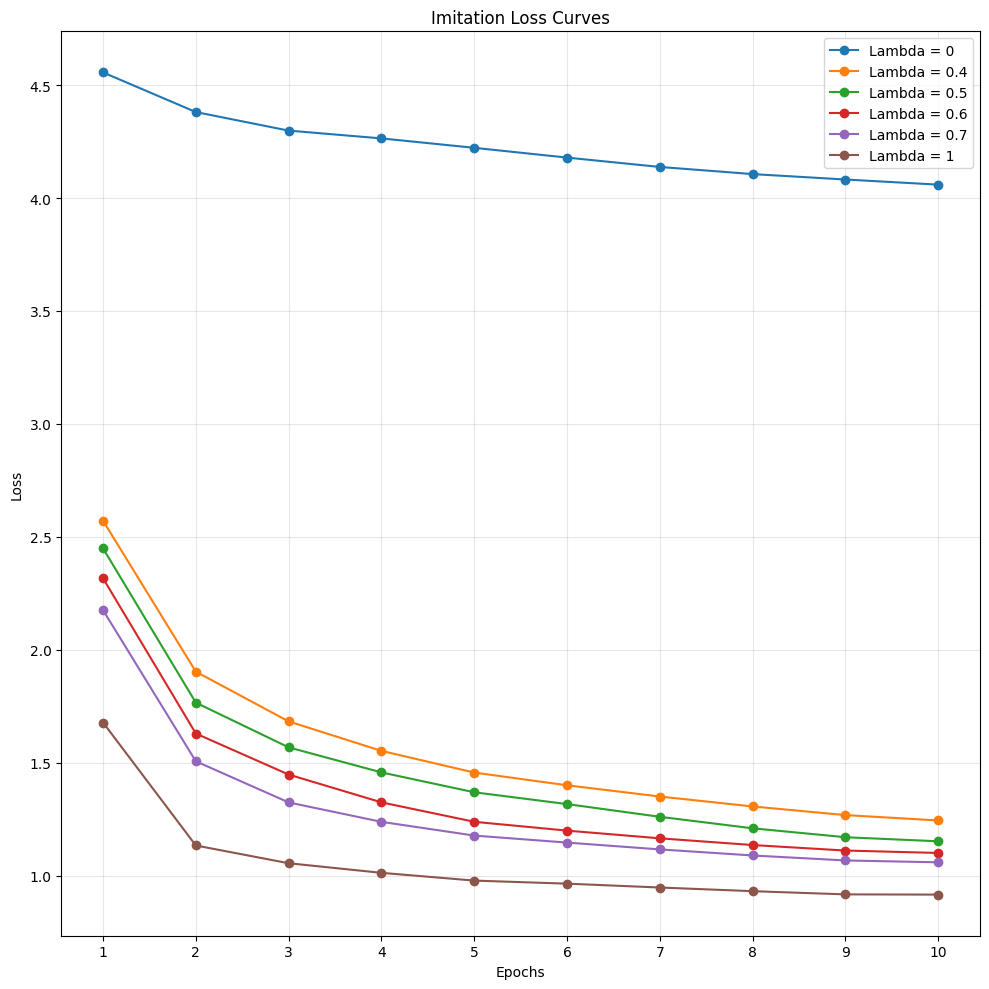

In [25]:
plot_losses(alphas, imitation_loss, loss_type='Imitation')

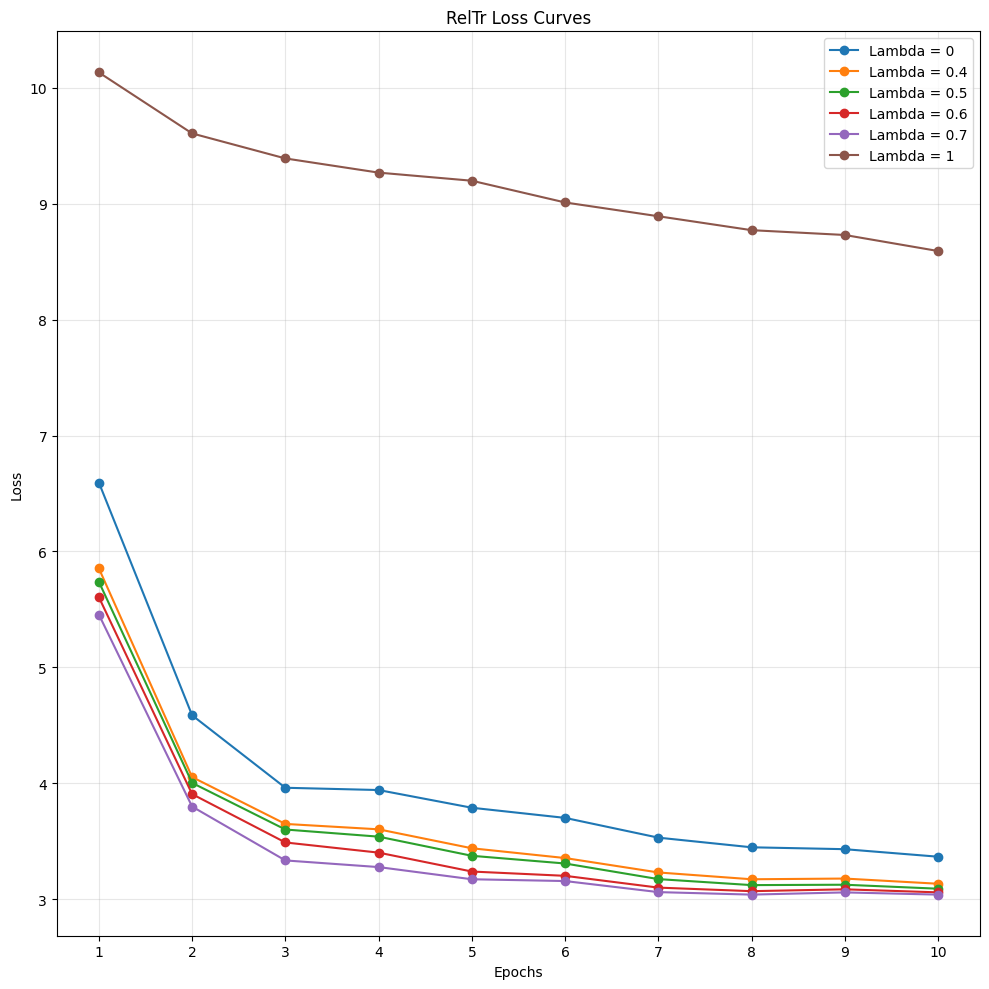

In [26]:
plot_losses(alphas, task_loss, loss_type='RelTr')

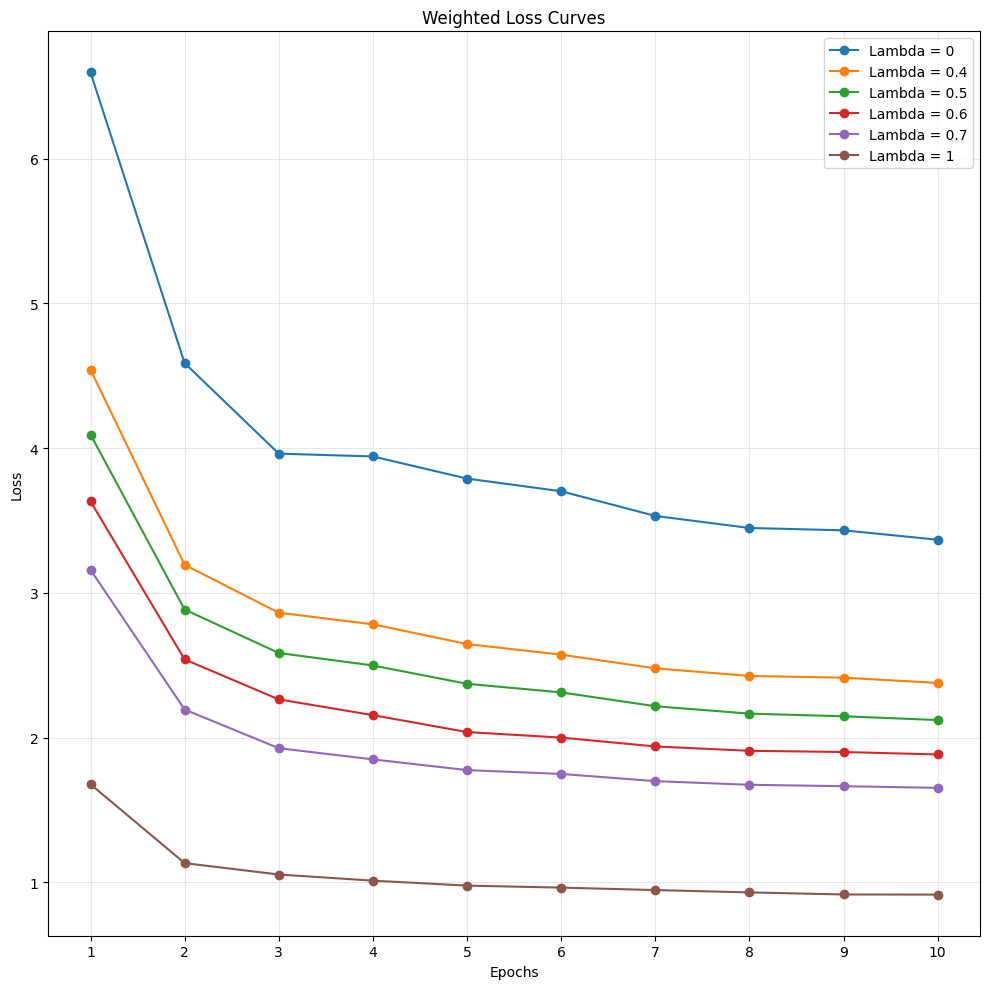

In [27]:
plot_losses(alphas, alpha_loss, 'Weighted')

In [28]:
import re
import os
import argparse
from collections import defaultdict

def extract_metrics(file_path):
    """Extract important metrics from the evaluation file."""
    with open(file_path, 'r') as file:
        content = file.read()

    # Dictionary to store metrics for each layer
    metrics = defaultdict(dict)

    # Find all layer evaluations
    layer_pattern = r'Evaluation for exit at layer- (\d+)'
    layer_matches = re.finditer(layer_pattern, content)

    for layer_match in layer_matches:
        layer = int(layer_match.group(1))

        # Get content for this layer until the next layer or end of file
        start_pos = layer_match.end()
        next_layer = re.search(layer_pattern, content[start_pos:])
        if next_layer:
            end_pos = start_pos + next_layer.start()
            layer_content = content[start_pos:end_pos]
        else:
            layer_content = content[start_pos:]

        # Extract overall recall metrics
        recall_pattern = r'=+sgdet=+\s*R@20: ([\d.]+)\s*R@50: ([\d.]+)\s*R@100: ([\d.]+)'
        recall_match = re.search(recall_pattern, layer_content)
        if recall_match:
            metrics[layer]['R@20'] = float(recall_match.group(1))
            metrics[layer]['R@50'] = float(recall_match.group(2))
            metrics[layer]['R@100'] = float(recall_match.group(3))

        # Extract mean recall metrics
        mean_recall_pattern = r'=+sgdet\s+mean recall with constraint=+\s*mR@20:\s*([\d.]+)\s*mR@50:\s*([\d.]+)\s*mR@100:\s*([\d.]+)'
        mean_recall_match = re.search(mean_recall_pattern, layer_content)
        if mean_recall_match:
            metrics[layer]['mR@20'] = float(mean_recall_match.group(1))
            metrics[layer]['mR@50'] = float(mean_recall_match.group(2))
            metrics[layer]['mR@100'] = float(mean_recall_match.group(3))

        # Extract error metrics
        error_pattern = r'class_error: ([\d.]+)\s+sub_error: ([\d.]+)\s+obj_error: ([\d.]+)\s+rel_error: ([\d.]+)'
        error_match = re.search(error_pattern, layer_content)
        if error_match:
            metrics[layer]['class_error'] = float(error_match.group(1))
            metrics[layer]['sub_error'] = float(error_match.group(2))
            metrics[layer]['obj_error'] = float(error_match.group(3))
            metrics[layer]['rel_error'] = float(error_match.group(4))

        # Extract IoU metrics (AP and AR)
        iou_patterns = [
            r'Average Precision\s+\(AP\) @\[ IoU=0.50:0.95 \| area=\s+all \| maxDets=100 \] = ([\d.]+)',
            r'Average Precision\s+\(AP\) @\[ IoU=0.50\s+\| area=\s+all \| maxDets=100 \] = ([\d.]+)',
            r'Average Recall\s+\(AR\) @\[ IoU=0.50:0.95 \| area=\s+all \| maxDets=100 \] = ([\d.]+)'
        ]

        iou_keys = ['AP_IoU_50_95', 'AP_IoU_50', 'AR_IoU_50_95']

        for pattern, key in zip(iou_patterns, iou_keys):
            match = re.search(pattern, layer_content)
            if match:
                metrics[layer][key] = float(match.group(1))

    return metrics

def format_output(metrics, output_format='text'):
    """Format metrics for output in specified format."""
    if output_format == 'csv':
        # CSV header
        lines = ['Layer,R@20,R@50,R@100,mR@20,mR@50,mR@100,class_error,rel_error,AP_IoU_50_95,AP_IoU_50,AR_IoU_50_95']

        # CSV rows
        for layer in sorted(metrics.keys()):
            m = metrics[layer]
            row = [
                str(layer),
                f"{m.get('R@20', 'N/A'):.6f}",
                f"{m.get('R@50', 'N/A'):.6f}",
                f"{m.get('R@100', 'N/A'):.6f}",
                f"{m.get('mR@20', 'N/A'):.6f}",
                f"{m.get('mR@50', 'N/A'):.6f}",
                f"{m.get('mR@100', 'N/A'):.6f}",
                f"{m.get('class_error', 'N/A'):.2f}",
                f"{m.get('rel_error', 'N/A'):.2f}",
                f"{m.get('AP_IoU_50_95', 'N/A'):.3f}",
                f"{m.get('AP_IoU_50', 'N/A'):.3f}",
                f"{m.get('AR_IoU_50_95', 'N/A'):.3f}"
            ]
            lines.append(','.join(row))

        return '\n'.join(lines)
    else:
        # Text format with tabular output
        lines = []
        lines.append("Layer  R@20      R@50      R@100     mR@20     mR@50     mR@100    cls_err   rel_err   AP50:95   AP50      AR")
        lines.append("-" * 110)

        for layer in sorted(metrics.keys()):
            m = metrics[layer]
            line = (
                f"{layer:<6}"
                f"{m.get('R@20', 'N/A'):<10.6f}"
                f"{m.get('R@50', 'N/A'):<10.6f}"
                f"{m.get('R@100', 'N/A'):<10.6f}"
                f"{m.get('mR@20', 'N/A'):<10.6f}"
                f"{m.get('mR@50', 'N/A'):<10.6f}"
                f"{m.get('mR@100', 'N/A'):<10.6f}"
                f"{m.get('class_error', 'N/A'):<10.2f}"
                f"{m.get('rel_error', 'N/A'):<10.2f}"
                f"{m.get('AP_IoU_50_95', 'N/A'):<10.3f}"
                f"{m.get('AP_IoU_50', 'N/A'):<10.3f}"
                f"{m.get('AR_IoU_50_95', 'N/A'):<10.3f}"
            )
            lines.append(line)

        return '\n'.join(lines)

def extract_per_relationship_metrics(file_path):
    """Extract per-relationship recall metrics if available."""
    with open(file_path, 'r') as file:
        content = file.read()

    # Find all relationship blocks
    relationship_pattern = r'relationship:\s+([^\n]+)\s+=+sgdet=+\s*R@20: ([\d.]+|nan)\s*R@50: ([\d.]+|nan)\s*R@100: ([\d.]+|nan)'
    relationship_matches = re.finditer(relationship_pattern, content)

    relationships = {}
    for match in relationship_matches:
        rel_name = match.group(1).strip()
        r20 = match.group(2)
        r50 = match.group(3)
        r100 = match.group(4)

        # Convert to float if possible, otherwise keep as 'nan'
        r20 = float(r20) if r20 != 'nan' else float('nan')
        r50 = float(r50) if r50 != 'nan' else float('nan')
        r100 = float(r100) if r100 != 'nan' else float('nan')

        relationships[rel_name] = {
            'R@20': r20,
            'R@50': r50,
            'R@100': r100
        }

    return relationships

# def main():
#     parser = argparse.ArgumentParser(description='Extract metrics from scene graph detection evaluation logs.')
#     parser.add_argument('file', help='Path to the evaluation log file')
#     parser.add_argument('--format', choices=['text', 'csv'], default='text', help='Output format (default: text)')
#     parser.add_argument('--relationships', action='store_true', help='Extract per-relationship metrics if available')

#     args = parser.parse_args()

#     metrics = extract_metrics(args.file)
#     print(format_output(metrics, args.format))

#     if args.relationships:
#         relationships = extract_per_relationship_metrics(args.file)
#         if relationships:
#             print("\nPer-Relationship Metrics (R@20):")
#             print("-" * 40)
#             # Sort by R@20 value in descending order
#             sorted_rels = sorted(relationships.items(), key=lambda x: x[1]['R@20'], reverse=True)
#             for rel, values in sorted_rels:
#                 if not np.isnan(values['R@20']):
#                     print(f"{rel:<20}: {values['R@20']:.6f}")

# if __name__ == "__main__":
#     main()

In [29]:
metrics = extract_metrics('train logs/metrics-10-0.txt')
print(format_output(metrics))

Layer  R@20      R@50      R@100     mR@20     mR@50     mR@100    cls_err   rel_err   AP50:95   AP50      AR
--------------------------------------------------------------------------------------------------------------
0     0.047936  0.057043  0.060262  0.012785  0.016801  0.018219  69.16     66.67     0.036     0.080     0.145     
1     0.064923  0.078731  0.083800  0.016845  0.020108  0.021946  63.55     63.89     0.042     0.094     0.164     
2     0.088640  0.102804  0.108389  0.024014  0.028356  0.030787  59.81     61.11     0.053     0.119     0.185     
3     0.118357  0.145128  0.153896  0.028567  0.035600  0.039440  50.47     66.67     0.066     0.149     0.209     
4     0.151189  0.180977  0.196171  0.038044  0.051615  0.057949  42.99     63.89     0.082     0.185     0.236     


In [30]:
metrics = extract_metrics('train logs/metrics-10-0.4.txt')
print(format_output(metrics))

Layer  R@20      R@50      R@100     mR@20     mR@50     mR@100    cls_err   rel_err   AP50:95   AP50      AR
--------------------------------------------------------------------------------------------------------------
0     0.098995  0.122900  0.133431  0.027470  0.036001  0.039858  49.53     72.22     0.051     0.120     0.188     
1     0.113324  0.141114  0.154033  0.035114  0.042721  0.047664  50.47     75.00     0.060     0.138     0.208     
2     0.133764  0.164490  0.177024  0.038125  0.048168  0.052679  44.86     69.44     0.072     0.163     0.227     
3     0.153116  0.187163  0.201111  0.046005  0.058287  0.063503  45.79     66.67     0.083     0.183     0.247     
4     0.167450  0.206348  0.225038  0.045013  0.063768  0.070593  35.51     61.11     0.095     0.204     0.262     


In [31]:
metrics = extract_metrics('train logs/metrics-10-0.5.txt')
print(format_output(metrics))

Layer  R@20      R@50      R@100     mR@20     mR@50     mR@100    cls_err   rel_err   AP50:95   AP50      AR
--------------------------------------------------------------------------------------------------------------
0     0.107964  0.135058  0.147513  0.028625  0.038644  0.045209  52.34     72.22     0.056     0.131     0.203     
1     0.123957  0.152662  0.166835  0.035357  0.046675  0.051241  48.60     77.78     0.070     0.156     0.231     
2     0.141586  0.174575  0.192028  0.038365  0.052359  0.058768  50.47     66.67     0.082     0.179     0.250     
3     0.157330  0.192333  0.208332  0.045741  0.058645  0.064563  41.12     69.44     0.093     0.199     0.264     
4     0.167407  0.207707  0.226572  0.043703  0.063548  0.070239  35.51     61.11     0.104     0.217     0.282     


In [32]:
metrics = extract_metrics('train logs/metrics-10-0.6.txt')
print(format_output(metrics))

Layer  R@20      R@50      R@100     mR@20     mR@50     mR@100    cls_err   rel_err   AP50:95   AP50      AR
--------------------------------------------------------------------------------------------------------------
0     0.117679  0.146638  0.162938  0.032579  0.042591  0.048828  50.47     77.78     0.064     0.149     0.223     
1     0.133266  0.165990  0.181053  0.039014  0.051371  0.056635  45.79     72.22     0.077     0.171     0.247     
2     0.147956  0.184614  0.200871  0.042752  0.053413  0.059873  48.60     63.89     0.089     0.192     0.264     
3     0.160282  0.198554  0.216498  0.043813  0.060861  0.067660  39.25     66.67     0.102     0.214     0.279     
4     0.171904  0.210958  0.230086  0.047323  0.066122  0.072163  35.51     61.11     0.112     0.229     0.293     


In [33]:
metrics = extract_metrics('train logs/metrics-10-0.7.txt')
print(format_output(metrics))

Layer  R@20      R@50      R@100     mR@20     mR@50     mR@100    cls_err   rel_err   AP50:95   AP50      AR
--------------------------------------------------------------------------------------------------------------
0     0.126409  0.156996  0.173077  0.036478  0.049446  0.055963  48.60     77.78     0.065     0.153     0.225     
1     0.140032  0.173771  0.190609  0.041698  0.053656  0.060762  46.73     80.56     0.079     0.176     0.246     
2     0.153392  0.189698  0.206914  0.046162  0.059143  0.066695  42.06     72.22     0.093     0.199     0.268     
3     0.166055  0.202326  0.220847  0.047127  0.061539  0.068716  40.19     69.44     0.104     0.219     0.283     
4     0.172994  0.213638  0.232935  0.048922  0.068607  0.075043  35.51     63.89     0.114     0.233     0.297     


In [34]:
metrics = extract_metrics('train logs/metrics-10-1.txt')
print(format_output(metrics))

Layer  R@20      R@50      R@100     mR@20     mR@50     mR@100    cls_err   rel_err   AP50:95   AP50      AR
--------------------------------------------------------------------------------------------------------------
0     0.004644  0.009614  0.011807  0.000711  0.001620  0.005672  100.00    97.22     0.001     0.005     0.009     
1     0.005952  0.010861  0.014416  0.000937  0.005170  0.005890  100.00    100.00    0.002     0.008     0.012     
2     0.011799  0.015602  0.018138  0.002095  0.006791  0.007335  100.00    91.67     0.003     0.015     0.020     
3     0.020326  0.023626  0.026190  0.005563  0.011028  0.011826  100.00    86.11     0.008     0.032     0.038     
4     0.035156  0.043817  0.048634  0.013842  0.027024  0.029017  59.81     75.00     0.023     0.066     0.075     


In [35]:
metrics = extract_metrics('train logs/metrics-30-0.7.txt')
print(format_output(metrics))

Layer  R@20      R@50      R@100     mR@20     mR@50     mR@100    cls_err   rel_err   AP50:95   AP50      AR
--------------------------------------------------------------------------------------------------------------
0     0.138807  0.175143  0.192614  0.041964  0.056637  0.067036  31.78     63.89     0.075     0.173     0.237     
1     0.155069  0.192669  0.211521  0.046887  0.066505  0.075951  30.84     66.67     0.089     0.199     0.259     
2     0.165356  0.203672  0.224191  0.049582  0.071103  0.078378  27.10     69.44     0.099     0.215     0.276     
3     0.174544  0.215325  0.235548  0.053369  0.072393  0.080216  30.84     69.44     0.109     0.231     0.288     
4     0.182504  0.225312  0.245393  0.055831  0.075142  0.082384  28.04     61.11     0.119     0.244     0.304     


In [37]:
metrics = extract_metrics('train logs/metrics-50-0.7.txt')
print(format_output(metrics))

Layer  R@20      R@50      R@100     mR@20     mR@50     mR@100    cls_err   rel_err   AP50:95   AP50      AR
--------------------------------------------------------------------------------------------------------------
0     0.144571  0.179587  0.197272  0.041675  0.058665  0.070219  31.78     66.67     0.075     0.172     0.229     
1     0.156975  0.194267  0.214369  0.050011  0.067977  0.076866  31.78     69.44     0.088     0.195     0.252     
2     0.169527  0.208172  0.230040  0.050518  0.069852  0.079135  28.97     63.89     0.098     0.215     0.272     
3     0.178338  0.218812  0.241248  0.054274  0.076020  0.084134  30.84     63.89     0.110     0.234     0.289     
4     0.182652  0.226538  0.248965  0.055597  0.076842  0.087992  29.91     61.11     0.122     0.250     0.308     


In [38]:
metrics = extract_metrics('train logs/metrics-50-0.7.txt')
print(format_output(metrics, output_format='csv'))

Layer,R@20,R@50,R@100,mR@20,mR@50,mR@100,class_error,rel_error,AP_IoU_50_95,AP_IoU_50,AR_IoU_50_95
0,0.144571,0.179587,0.197272,0.041675,0.058665,0.070219,31.78,66.67,0.075,0.172,0.229
1,0.156975,0.194267,0.214369,0.050011,0.067977,0.076866,31.78,69.44,0.088,0.195,0.252
2,0.169527,0.208172,0.230040,0.050518,0.069852,0.079135,28.97,63.89,0.098,0.215,0.272
3,0.178338,0.218812,0.241248,0.054274,0.076020,0.084134,30.84,63.89,0.110,0.234,0.289
4,0.182652,0.226538,0.248965,0.055597,0.076842,0.087992,29.91,61.11,0.122,0.250,0.308



=== METRICS TABLE ===
+---+-------+----------+----------+----------+----------+----------+----------+--------------+-----------+--------------+
|   | Layer |   R@20   |   R@50   |  R@100   |  mR@20   |  mR@50   |  mR@100  | AP_IoU_50_95 | AP_IoU_50 | AR_IoU_50_95 |
+---+-------+----------+----------+----------+----------+----------+----------+--------------+-----------+--------------+
| 0 |  0.0  | 0.144571 | 0.179587 | 0.197272 | 0.041675 | 0.058665 | 0.070219 |    0.075     |   0.172   |    0.229     |
| 1 |  1.0  | 0.156975 | 0.194267 | 0.214369 | 0.050011 | 0.067977 | 0.076866 |    0.088     |   0.195   |    0.252     |
| 2 |  2.0  | 0.169527 | 0.208172 | 0.23004  | 0.050518 | 0.069852 | 0.079135 |    0.098     |   0.215   |    0.272     |
| 3 |  3.0  | 0.178338 | 0.218812 | 0.241248 | 0.054274 | 0.07602  | 0.084134 |     0.11     |   0.234   |    0.289     |
| 4 |  4.0  | 0.182652 | 0.226538 | 0.248965 | 0.055597 | 0.076842 | 0.087992 |    0.122     |   0.25    |    0.308     |
+

<ipython-input-43-aef3ba29326e>:189: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  improvement_df = pd.concat([improvement_df, pd.DataFrame([new_row])], ignore_index=True)
<ipython-input-43-aef3ba29326e>:239: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.075000' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  improvements.at[i, col] = f"{row[col]:.6f}"
<ipython-input-43-aef3ba29326e>:239: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.122000' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  

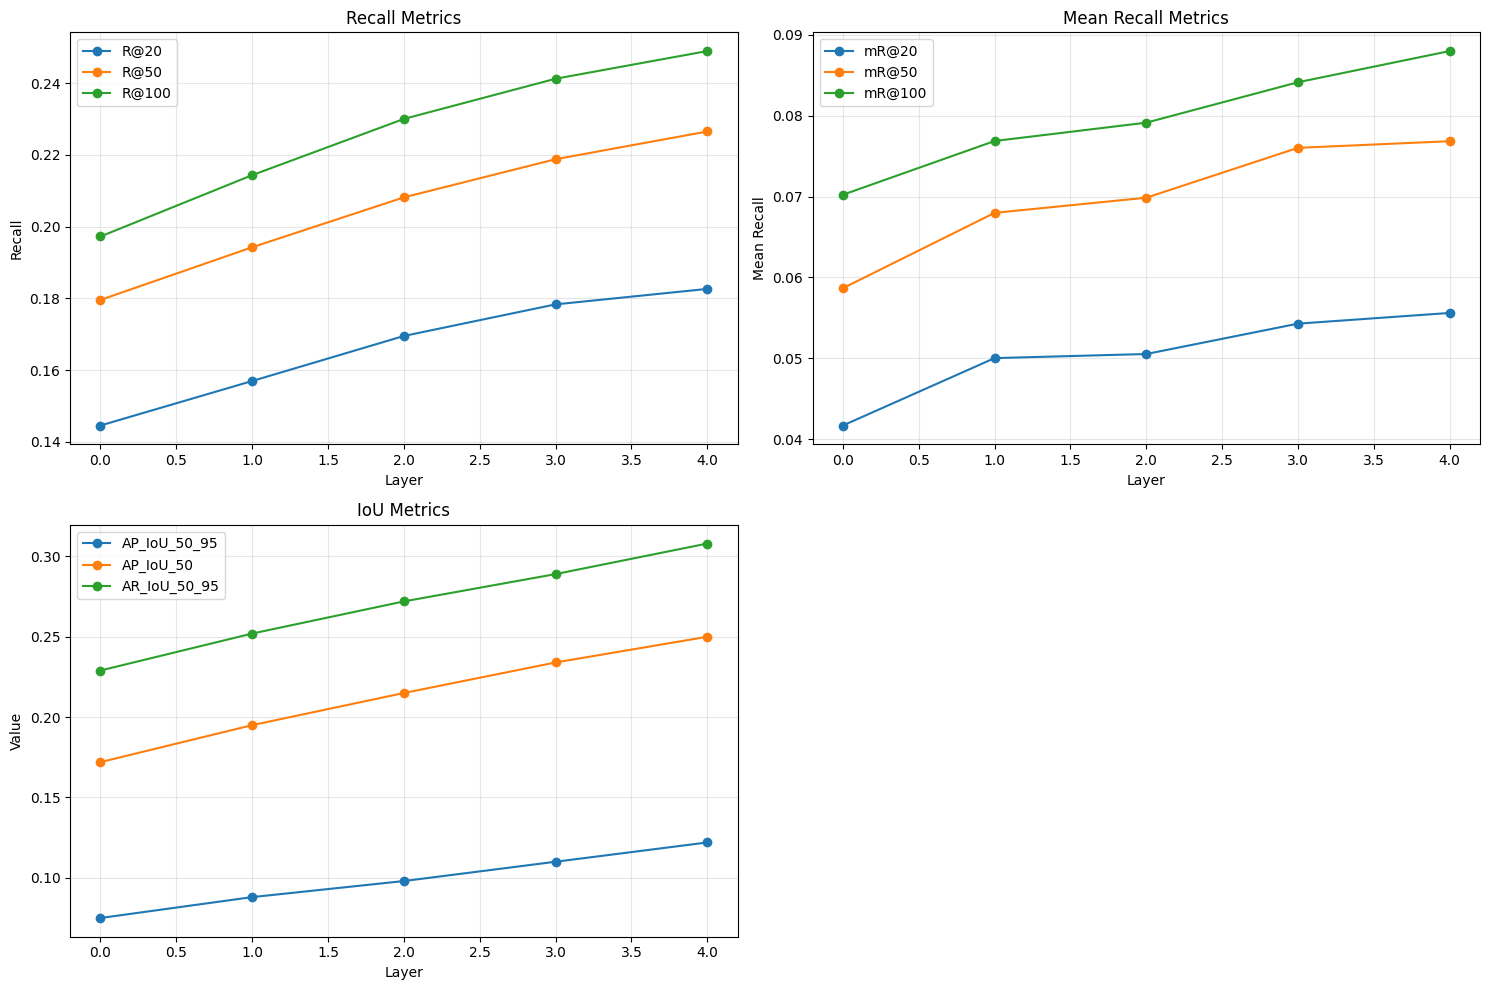

In [43]:
import pandas as pd
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tabulate import tabulate

def read_metrics_csv(file_path):
    """Read the CSV file and return a pandas DataFrame."""
    try:
        df = pd.read_csv(file_path)
        # Convert Layer column to integer for proper sorting
        df['Layer'] = df['Layer'].astype(int)
        # Sort by Layer
        df = df.sort_values('Layer')
        return df
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None

def create_formatted_table(df, metrics=None):
    """Create a well-formatted table for the specified metrics."""
    if metrics is None:
        # Default to these key metrics if none specified
        metrics = ['R@20', 'R@50', 'R@100', 'mR@20', 'mR@50', 'mR@100',
                  'AP_IoU_50_95', 'AP_IoU_50', 'AR_IoU_50_95']

    # Filter the DataFrame to include only the specified metrics
    table_df = df[['Layer'] + metrics]

    # Format the table using tabulate
    table = tabulate(table_df, headers='keys', tablefmt='pretty', floatfmt='.6f')
    return table

def create_error_table(df):
    """Create a formatted table specifically for error metrics."""
    error_metrics = ['class_error', 'rel_error']
    if all(metric in df.columns for metric in error_metrics):
        error_df = df[['Layer'] + error_metrics]
        table = tabulate(error_df, headers='keys', tablefmt='pretty', floatfmt='.2f')
        return table
    return None

# def plot_metrics(df, output_file=None):
#     """Create plots of the metrics."""
#     # Set up the figure
#     plt.figure(figsize=(15, 10))

#     # Plot recall metrics
#     plt.subplot(2, 2, 1)
#     for metric in ['R@20', 'R@50', 'R@100']:
#         if metric in df.columns:
#             plt.plot(df['Layer'], df[metric], 'o-', label=metric)
#     plt.title('Recall Metrics')
#     plt.xlabel('Layer')
#     plt.ylabel('Recall')
#     plt.legend()
#     plt.grid(True, alpha=0.3)

#     # Plot mean recall metrics
#     plt.subplot(2, 2, 2)
#     for metric in ['mR@20', 'mR@50', 'mR@100']:
#         if metric in df.columns:
#             plt.plot(df['Layer'], df[metric], 'o-', label=metric)
#     plt.title('Mean Recall Metrics')
#     plt.xlabel('Layer')
#     plt.ylabel('Mean Recall')
#     plt.legend()
#     plt.grid(True, alpha=0.3)

#     # Plot error metrics
#     # plt.subplot(2, 2, 3)
#     # for metric in ['class_error', 'rel_error']:
#     #     if metric in df.columns:
#     #         plt.plot(df['Layer'], df[metric], 'o-', label=metric)
#     # plt.title('Error Metrics')
#     # plt.xlabel('Layer')
#     # plt.ylabel('Error Rate (%)')
#     # plt.legend()
#     # plt.grid(True, alpha=0.3)

#     # Plot IoU metrics
#     plt.subplot(2, 2, 4)
#     for metric in ['AP_IoU_50_95', 'AP_IoU_50', 'AR_IoU_50_95']:
#         if metric in df.columns:
#             plt.plot(df['Layer'], df[metric], 'o-', label=metric)
#     plt.title('IoU Metrics')
#     plt.xlabel('Layer')
#     plt.ylabel('Value')
#     plt.legend()
#     plt.grid(True, alpha=0.3)

#     plt.tight_layout()

#     if output_file:
#         plt.savefig(output_file)
#         print(f"Plot saved to {output_file}")
#     else:
#         plt.show()


def plot_metrics(df, output_file=None):
    """Create plots of the metrics."""
    # Set up the figure
    plt.figure(figsize=(15, 10))

    # Plot recall metrics
    plt.subplot(2, 2, 1)
    for metric in ['R@20', 'R@50', 'R@100']:
        if metric in df.columns:
            plt.plot(df['Layer'], df[metric], 'o-', label=metric)
    plt.title('Recall Metrics')
    plt.xlabel('Layer')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot mean recall metrics
    plt.subplot(2, 2, 2)
    for metric in ['mR@20', 'mR@50', 'mR@100']:
        if metric in df.columns:
            plt.plot(df['Layer'], df[metric], 'o-', label=metric)
    plt.title('Mean Recall Metrics')
    plt.xlabel('Layer')
    plt.ylabel('Mean Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot IoU metrics
    plt.subplot(2, 2, 3)  # Moved IoU metrics to position 3 (bottom left)
    for metric in ['AP_IoU_50_95', 'AP_IoU_50', 'AR_IoU_50_95']:
        if metric in df.columns:
            plt.plot(df['Layer'], df[metric], 'o-', label=metric)
    plt.title('IoU Metrics')
    plt.xlabel('Layer')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Fourth subplot is left empty
    plt.subplot(2, 2, 4)
    plt.axis('off')  # Turn off axis for the empty plot

    plt.tight_layout()

    if output_file:
        plt.savefig(output_file)
        print(f"Plot saved to {output_file}")
    else:
        plt.show()

def calculate_improvements(df):
    """Calculate the percentage improvement from first to last layer."""
    if len(df) < 2:
        return None

    first_layer = df.iloc[0]
    last_layer = df.iloc[-1]

    improvement_df = pd.DataFrame(columns=['Metric', 'First Layer', 'Last Layer', 'Absolute Diff', 'Improvement %'])

    for column in df.columns:
        if column == 'Layer':
            continue

        first_val = first_layer[column]
        last_val = last_layer[column]

        # Skip if NaN values
        if pd.isna(first_val) or pd.isna(last_val):
            continue

        abs_diff = last_val - first_val

        # For error metrics, lower is better
        if column in ['class_error', 'sub_error', 'obj_error', 'rel_error']:
            pct_improvement = -100 * abs_diff / first_val if first_val != 0 else float('inf')
        else:
            pct_improvement = 100 * abs_diff / first_val if first_val != 0 else float('inf')

        new_row = {
            'Metric': column,
            'First Layer': first_val,
            'Last Layer': last_val,
            'Absolute Diff': abs_diff,
            'Improvement %': pct_improvement
        }

        improvement_df = pd.concat([improvement_df, pd.DataFrame([new_row])], ignore_index=True)

    # Sort by improvement percentage (absolute value)
    improvement_df['Abs Improvement %'] = improvement_df['Improvement %'].abs()
    improvement_df = improvement_df.sort_values('Abs Improvement %', ascending=False)
    improvement_df = improvement_df.drop(columns=['Abs Improvement %'])

    return improvement_df

def main():
    # parser = argparse.ArgumentParser(description='Process metrics CSV and create formatted tables.')
    # parser.add_argument('csv_file', help='Path to the metrics CSV file')
    # parser.add_argument('--plot', action='store_true', help='Generate plots of the metrics')
    # parser.add_argument('--plot-file', help='Save the plot to the specified file')
    # parser.add_argument('--metrics', nargs='+', help='Specific metrics to include in the table')

    # args = parser.parse_args()
    plot = True
    csv_file = 'train logs/metrics-50-0.7.csv'
    # plot_file = 'plot.png'

    # Read the CSV file
    df = read_metrics_csv(csv_file)
    if df is None:
        return

    # Create and print the tables
    print("\n=== METRICS TABLE ===")
    table = create_formatted_table(df)
    print(table)

    print("\n=== ERROR METRICS ===")
    error_table = create_error_table(df)
    if error_table:
        print(error_table)

    # Calculate and print improvements
    improvements = calculate_improvements(df)
    if improvements is not None:
        print("\n=== IMPROVEMENT ANALYSIS ===")
        # Format the improvement table
        for col in ['First Layer', 'Last Layer', 'Absolute Diff']:
            try:
                if improvements[col].dtype in [np.float64, np.float32]:
                    if col in ['First Layer', 'Last Layer']:
                        # Format based on the metric type
                        for i, row in improvements.iterrows():
                            if row['Metric'] in ['class_error', 'sub_error', 'obj_error', 'rel_error']:
                                improvements.at[i, col] = f"{row[col]:.2f}"
                            else:
                                improvements.at[i, col] = f"{row[col]:.6f}"
                    else:
                        # Absolute diff
                        improvements[col] = improvements[col].map(lambda x: f"{x:.6f}")
            except:
                pass

        # Format improvement percentage
        improvements['Improvement %'] = improvements['Improvement %'].map(lambda x: f"{x:.2f}%" if not pd.isna(x) else "N/A")

        # Print the formatted table
        print(tabulate(improvements, headers='keys', tablefmt='pretty', showindex=False))

    # Generate plots if requested
    if plot:
        plot_metrics(df, None)

if __name__ == "__main__":
    main()